In [1]:
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt

In [2]:
z1_raw = loadmat('data_from_Fabiola/zscore_song.mat')
z2_raw = loadmat('data_from_Fabiola/zscore_deafening.mat')

In [3]:
z_correct, z_pert = z1_raw['zscore_song'], z1_raw['zscore_songwn']
z_predeaf, z_postdeaf = z2_raw['zscore_pre'], z2_raw['zscore_post']

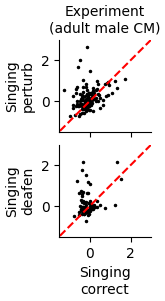

In [4]:
fig, ax = plt.subplots(2, figsize=(3, 3), sharex='all')
ax[0].plot(z_correct, z_pert, '.', ms=3, color='k')
ax[1].plot(z_predeaf, z_postdeaf, '.', ms=3, color='k')
for i, l in enumerate(['Singing\nperturb', 'Singing\ndeafen']):
    ax[i].plot([-3,6], [-3,6], c='r', ls='--')
    ax[i].set(xlim=[-1.5,3], ylim=[-1.5,3], xticks=[0,2], yticks=[0,2], 
              ylabel=l)
    ax[i].axes.set_aspect('equal')
ax[0].set_title('Experiment\n(adult male CM)')
ax[-1].set(xlabel='Singing\ncorrect')
# fig.text(0.6, 0, 'z-scored singing ' + r'$( = z_{Correct}$)', ha='center')
fig.savefig('svg/joint_dist_c_vs_nc_experiment.svg', bbox_inches='tight')